In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
data = pd.read_csv("C:/Users/user/Desktop/deep-learning-programing-project/train_data.csv")

# 라벨 제거 및 전치
data = data.drop("LABEL", axis=1).T

# 특정 행을 테스트 데이터로 분리
test_data = data.iloc[:, :1]  # 첫 번째 열을 테스트 데이터로 사용
train_data = data.iloc[:, 1:]  # 나머지를 학습 데이터로 사용

# 데이터 정규화
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data.T).T  # fit_transform을 통해 정규화
scaled_test_data = scaler.transform(test_data.T).T  # transform을 통해 정규화

scaled_train_df = pd.DataFrame(scaled_train_data, index=train_data.index, columns=train_data.columns)
scaled_test_df = pd.DataFrame(scaled_test_data, index=test_data.index, columns=test_data.columns)

In [2]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100

X_train, Y_train = create_dataset(scaled_train_df.values, time_step)
X_test, Y_test = create_dataset(scaled_test_df.values, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, X_test.shape)


(3096, 100, 1) (3096, 100, 1)


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.fc(output[:, -1, :])
        return output

# 하이퍼파라미터 설정
input_size = X_train.shape[2]
hidden_size = 100
num_layers = 2
dropout_rate = 0.3
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 테스트 데이터로 평가
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            test_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], Train Loss: 0.0800, Test Loss: 0.0536
Epoch [2/100], Train Loss: 0.0665, Test Loss: 0.0468
Epoch [3/100], Train Loss: 0.0750, Test Loss: 0.0290
Epoch [4/100], Train Loss: 0.0741, Test Loss: 0.0280
Epoch [5/100], Train Loss: 0.0755, Test Loss: 0.0279
Epoch [6/100], Train Loss: 0.0722, Test Loss: 0.0265
Epoch [7/100], Train Loss: 0.0701, Test Loss: 0.0255
Epoch [8/100], Train Loss: 0.0670, Test Loss: 0.0251
Epoch [9/100], Train Loss: 0.0631, Test Loss: 0.0237
Epoch [10/100], Train Loss: 0.0565, Test Loss: 0.0215
Epoch [11/100], Train Loss: 0.0448, Test Loss: 0.0186
Epoch [12/100], Train Loss: 0.0357, Test Loss: 0.0163
Epoch [13/100], Train Loss: 0.0301, Test Loss: 0.0146
Epoch [14/100], Train Loss: 0.0288, Test Loss: 0.0140
Epoch [15/100], Train Loss: 0.0284, Test Loss: 0.0134
Epoch [16/100], Train Loss: 0.0268, Test Loss: 0.0129
Epoch [17/100], Train Loss: 0.0257, Test Loss: 0.0123
Epoch [18/100], Train Loss: 0.0248, Test Loss: 0.0121
Epoch [19/100], Train Loss: 0.0248, T

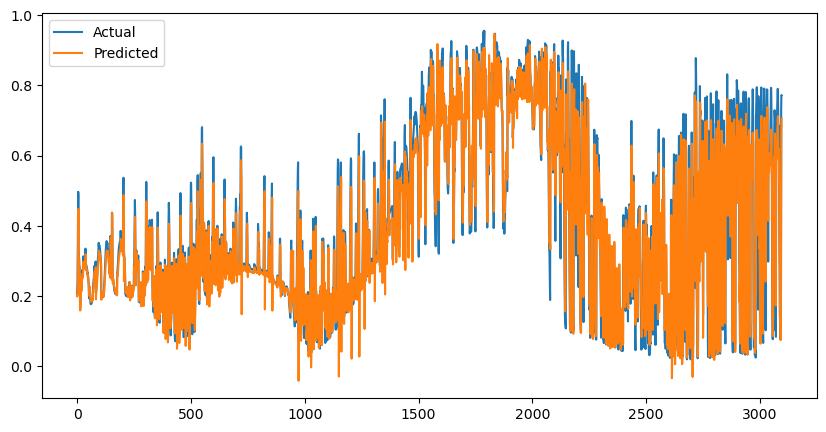

In [4]:
# 모델 예측 및 평가
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Flatten the lists
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()